In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


try:
    import joblib
except ImportError:
    joblib = None

In [ ]:
# acces a notre train data
CSV_PATH = "C:\Master USPN\Cours M2 Big Data\DataScience Ecosysteme\projet blood pressure\donnees_entrainement.csv"
SEP = ","

OUTPUT_DIR = "outputs_bp"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Seuils médicaux du blood_pressure
SYS_LOW, SYS_HIGH = 90, 130
DIA_LOW, DIA_HIGH = 60, 80

In [ ]:
# Chargement et préparation de la base

df = pd.read_csv(CSV_PATH, sep=SEP)
df.columns = df.columns.str.strip()

# Typage
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

num_cols = ["Age", "Systolic", "Diastolic", "Glucose", "Cholesterol", "AVC_Risk_Score"]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.head()


,Date,Patient,Age,Sexe,Fumeur,Diabete,Systolic,Diastolic,Glucose,Cholesterol,AVC_Risk_Score,Target_Risk
0,2026-01-04 17:08:31.743121+01:00,Adrien Leroux,34,male,0,NaN,123,79,68.4,1.48,0.0,Low Risk
1,2026-01-04 17:08:37.192132+01:00,Henri Alves,58,male,0,NaN,155,111,66.2,1.75,3.0,Low Risk
2,2026-01-04 17:08:42.196063+01:00,Augustin Le Gall,80,male,0,Type 2,156,106,201.5,2.25,5.5,High Risk
3,2026-01-04 17:08:47.203652+01:00,Xavier Georges Le Lemoine,43,male,0,NaN,126,83,98.5,1.69,0.0,Low Risk
4,2026-01-04 17:08:52.207916+01:00,Augustin Le Gall,80,male,0,Type 2,157,100,147.7,2.25,5.5,High Risk


In [67]:
df['Target_Risk'].value_counts(normalize=True)

Target_Risk
Low Risk     0.661667
High Risk    0.338333
Name: proportion, dtype: float64

In [ ]:
# Variable metier des seuil

df["sys_high_flag"] = (df["Systolic"] > SYS_HIGH).astype(int)
df["sys_low_flag"]  = (df["Systolic"] < SYS_LOW).astype(int)

df["dia_high_flag"] = (df["Diastolic"] > DIA_HIGH).astype(int)
df["dia_low_flag"]  = (df["Diastolic"] < DIA_LOW).astype(int)

df[["Systolic", "Diastolic", "sys_high_flag", "dia_high_flag"]].head()


,Systolic,Diastolic,sys_high_flag,dia_high_flag
0,123,79,0,0
1,155,111,1,1
2,156,106,1,1
3,126,83,0,1
4,157,100,1,1


In [ ]:
# Definition correcte target

# TARGET = Risque d'AVC
y = df["Target_Risk"]
y = y.map({'Low Risk': 0, 'High Risk': 1})

# Features : On supprime "AVC_Risk_Score" pour éviter le data leakage

X = df.drop(columns=["Target_Risk", "Patient", "Date","AVC_Risk_Score"], errors="ignore")

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1200, 12)
y shape: (1200,)


In [70]:
X.columns

Index(['Age', 'Sexe', 'Fumeur', 'Diabete', 'Systolic', 'Diastolic', 'Glucose',
       'Cholesterol', 'sys_high_flag', 'sys_low_flag', 'dia_high_flag',
       'dia_low_flag'],
      dtype='object')

In [ ]:
## On divisine notre jeu de donnes en trois groupe : Train, Test & Validation

# 60 % train / 40 % temporaire
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y)

# 20 % validation / 20 % test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (720, 12)
Validation: (240, 12)
Test: (240, 12)


In [ ]:
# Data Preprocessing : Traitement de valeurs manquantes, Standardisation, Encodage

num_features = X.select_dtypes(include=["number"]).columns.tolist()
cat_features = X.select_dtypes(exclude=["number"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

In [73]:
y_temp

992     1
1176    0
722     1
283     0
548     0
       ..
406     1
596     0
638     0
150     1
998     0
Name: Target_Risk, Length: 480, dtype: int64

In [ ]:
# Modele 1 : Regression logistique

log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_reg.fit(X_train, y_train)

y_val_pred_lr = log_reg.predict(X_val)
y_val_proba_lr = log_reg.predict_proba(X_val)[:, 1]

print("=== Régression Logistique — Validation ===")
print(classification_report(y_val, y_val_pred_lr))
print("AUC:", roc_auc_score(y_val, y_val_proba_lr))

=== Régression Logistique — Validation ===
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       159
           1       0.74      0.93      0.82        81

    accuracy                           0.87       240
   macro avg       0.85      0.88      0.86       240
weighted avg       0.88      0.87      0.87       240

AUC: 0.9658358568211818


In [ ]:
# On définit la Pipeline avec le nom "model"
log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, solver='liblinear')) 
])

# Selection des hyper-parametres a optimiser
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}] 
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# On cherche a maximiser le RECALL : Ne pas louper les patient à Haut_Risuqe (classe 1)
grid = GridSearchCV(
    log_reg, 
    param_grid, 
    scoring='recall', 
    cv=cv,
    n_jobs=-1)

grid.fit(X_train, y_train)

print(f"Meilleurs réglages : {grid.best_params_}")
print(f"Meilleur score de Rappel : {grid.best_score_:.3f}")

Meilleurs réglages : {'model__C': 0.1, 'model__class_weight': {0: 1, 1: 5}}
Meilleur score de Rappel : 0.992


In [82]:
pred = grid.predict(X_val)
pred_proba = grid.predict_proba(X_val)[:, 1]

print(classification_report(y_val, pred))
print("AUC:", roc_auc_score(y_val, pred_proba))

              precision    recall  f1-score   support

           0       0.98      0.74      0.85       159
           1       0.66      0.98      0.79        81

    accuracy                           0.82       240
   macro avg       0.82      0.86      0.82       240
weighted avg       0.87      0.82      0.83       240

AUC: 0.9658358568211818


In [ ]:
# Modèle 2 : Randon Forest

rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced", 
        random_state=42
    ))
])

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)
y_val_proba_rf = rf.predict_proba(X_val)[:, 1]

print("=== Random Forest — Validation ===")
print(classification_report(y_val, y_val_pred_rf))
print("AUC:", roc_auc_score(y_val, y_val_proba_rf))

=== Random Forest — Validation ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       159
           1       0.99      0.94      0.96        81

    accuracy                           0.97       240
   macro avg       0.98      0.97      0.97       240
weighted avg       0.98      0.97      0.97       240

AUC: 0.9958071278825996


In [ ]:
# Selection du meilleur Modèle

# Le score ROC AUC est indispensable car il mesure la capacité intrinseque du modele a 
# distinguer les patients a risque des patients sains sur l'ensemble des seuils possibles

auc_lr = roc_auc_score(y_val, y_val_proba_lr)
auc_rf = roc_auc_score(y_val, y_val_proba_rf)

best_model = rf if auc_rf > auc_lr else log_reg

print("Modèle retenu :", "Random Forest" if best_model == rf else "Régression Logistique")


Modèle retenu : Random Forest


In [ ]:
# Evaluation finale : Test Dataset

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("=== ÉVALUATION FINALE (TEST) ===")
print(classification_report(y_test, y_test_pred))
print("AUC Test:", roc_auc_score(y_test, y_test_proba))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))


=== ÉVALUATION FINALE (TEST) ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       159
           1       1.00      0.93      0.96        81

    accuracy                           0.97       240
   macro avg       0.98      0.96      0.97       240
weighted avg       0.98      0.97      0.97       240

AUC Test: 0.9992235422004814
Confusion matrix:
[[159   0]
 [  6  75]]


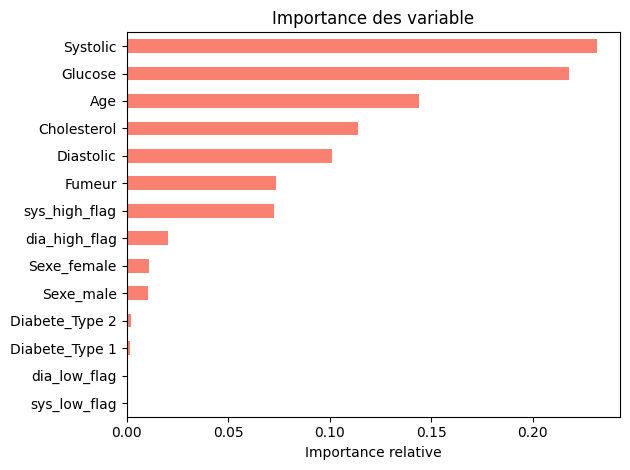

In [92]:
pipeline_finale = rf 

importances = pipeline_finale.named_steps['model'].feature_importances_

prep_step = pipeline_finale.named_steps['prep']
ohe_names = list(prep_step.transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_features))

feature_names = num_features + ohe_names

feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True).plot(kind='barh', color='salmon')
plt.title("Importance des variable")
plt.xlabel("Importance relative")
plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde du modèle 

if joblib is not None:
    joblib.dump(best_model, os.path.join(OUTPUT_DIR, "my_random_forest_avc.joblib"))

df.to_csv(os.path.join(OUTPUT_DIR, "dataset_enrichi.csv"), index=False)